In [104]:
from datasets import load_dataset

dataset = load_dataset('snli')


# label -1 is used if the gold label is missing, see: https://github.com/huggingface/datasets/issues/296
# therefore we remove all entries with label -1
dataset = dataset.filter(lambda x: x["label"] != -1)

labels = dataset.unique("label").keys()
num_labels = len(labels)

# shuffle the dataset to avoid any bias
dataset = dataset.shuffle(seed=42)

# rename label to labels, because the model expects a column named labels
dataset = dataset.rename_column("label", "labels")

print(f"{labels=}")
print(f"{num_labels=}")

Flattening the indices:   0%|          | 0/9824 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/9842 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/549367 [00:00<?, ? examples/s]

labels=dict_keys(['test', 'validation', 'train'])
num_labels=3


In [50]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [51]:
from transformers import BertModel

import torch.nn as nn

class NLIClassifier(nn.Module):
    def __init__(self, model, num_labels=3, freeze_bert=False):
        super(NLIClassifier, self).__init__()
        self.bert = model.to(device)
        # freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        for param in self.classifier.parameters():
            param.requires_grad = True
        self.to(device)

    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token representation
        logits = self.classifier(cls_output)
        return logits

model = BertModel.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    torch_dtype="auto",
).to(device)
nli_model = NLIClassifier(model, num_labels=3)

In [52]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# tokenize dataset
tokenized_dataset = dataset.map(lambda x: tokenizer(x["premise"], x["hypothesis"], add_special_tokens=True, truncation=True), batched=True)


Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

In [53]:
tokenized_dataset

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9824
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9842
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 549367
    })
})

In [54]:
# Dataloader with collate function moving data to device
# batch.items() returns probably something like this: 
#[
#  ('input_ids', tensor([[101, 2054, 2003, 2023, 102], [101, 2029, 3185, 2003, 102]])),
#  ('attention_mask', tensor([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])),
#  ('labels', tensor([0, 1]))
#]
# so we do not need the keys, just the values and send them to the device
def collate_fn_with_device(batch):
    batch = data_collator(batch)
    return {k: v.to(device) for k, v in batch.items()}

In [63]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# remove all text columns, because they are already tokenized
tokenized_dataset = tokenized_dataset.remove_columns(["premise", "hypothesis"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
traindataloader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True, collate_fn=collate_fn_with_device)
evaldataloader = DataLoader(tokenized_dataset["validation"], batch_size=32, shuffle=True, collate_fn=collate_fn_with_device)
testdataloader = DataLoader(tokenized_dataset["test"], batch_size=32, shuffle=True, collate_fn=collate_fn_with_device)

In [56]:
class Results:
    def __init__(self):
        self.loss = []
        self.acc = []
        self.epoch = []

    def add(self, loss, acc, epoch):
        self.loss.append(loss.item())
        self.acc.append(acc)
        self.epoch.append(epoch)

In [ ]:
from tqdm.auto import tqdm
import evaluate
import numpy as np
from transformers import get_scheduler

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, nli_model.parameters()), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(traindataloader)


progress_bar = tqdm(range(num_training_steps))
nli_model.to(device)
nli_model.train()

training_results = Results()
validation_results = Results()
i = 1

criterion = nn.CrossEntropyLoss()


def compute_statistics(nli_model, dataloader, results, step):
    eval_metric = evaluate.load("accuracy")
    total_loss = np.array([])
    for batch in dataloader:
        with torch.no_grad():
            outputs = nli_model(**batch)
        predictions = torch.argmax(outputs, dim=-1)
        eval_metric.add_batch(predictions=predictions, references=batch["labels"])
        total_loss = np.append(total_loss, criterion(outputs, batch["labels"]).item())
    results.add(total_loss.sum() / len(dataloader), eval_metric.compute()['accuracy'], step / len(dataloader))


# https://discuss.pytorch.org/t/how-to-calculate-the-validation-loss-during-each-epoch-of-training/145272/3
for epoch in range(num_epochs):
    for batch in traindataloader:
        optimizer.zero_grad()
        outputs = nli_model(**batch)
        loss = criterion(outputs, batch["labels"])
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
        i += 1
        if i % 5000 == 0:
            nli_model.eval()
            compute_statistics(nli_model, traindataloader, training_results, i)
            compute_statistics(nli_model, evaldataloader, validation_results, i)
            nli_model.train()


  0%|          | 0/51504 [00:00<?, ?it/s]

In [102]:
import evaluate

metric = evaluate.load("accuracy")
nli_model.eval()
for batch in testdataloader:
    # for model inference we don't need gradients
    with torch.no_grad():
        outputs = nli_model(**batch)

    logits = outputs
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

print("Accuracy:", metric.compute()['accuracy'])

Accuracy: 0.903807003257329


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import evaluate

metric = evaluate.load("confusion_matrix")
nli_model.eval()

# Iterate through the test dataloader
for batch in testdataloader:
    with torch.no_grad():
        outputs = nli_model(**batch)
        predictions = torch.argmax(outputs, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])

# Compute confusion matrix
conf_matrix = metric.compute()['confusion_matrix']

# Define class labels manually (adjust as needed)
labels = ["Neutral", "Entailment", "Contradiction"]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [105]:
import pickle

# see https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence

with open('training.pkl', 'wb') as outp:
    pickle.dump(training_results, outp, pickle.HIGHEST_PROTOCOL)

with open('validation.pkl', 'wb') as outp:
    pickle.dump(validation_results, outp, pickle.HIGHEST_PROTOCOL)

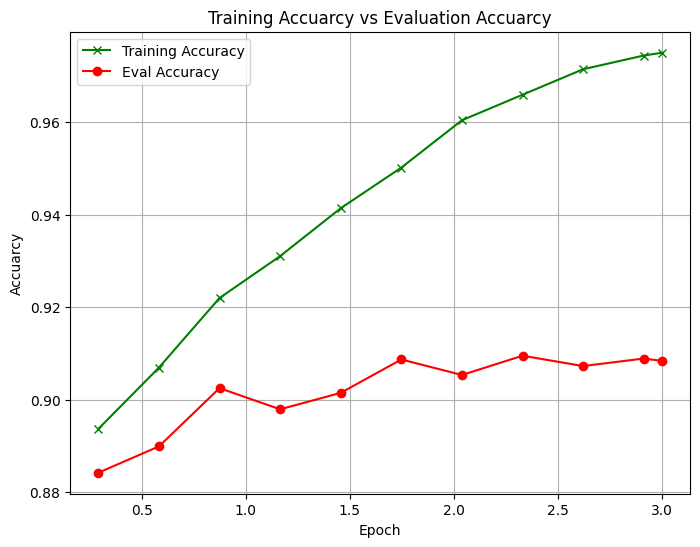

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

plt.plot(training_results.epoch, training_results.acc, label='Training Accuracy', color='green', marker='x')
plt.plot(validation_results.epoch, validation_results.acc, label='Eval Accuracy', color='red', marker='o')

# Labels and Title
plt.ylabel('Accuarcy')
plt.xlabel('Epoch')
plt.title('Training Accuarcy vs Evaluation Accuarcy')
plt.legend()
plt.grid(True)
plt.savefig('bert_base_acc.png')

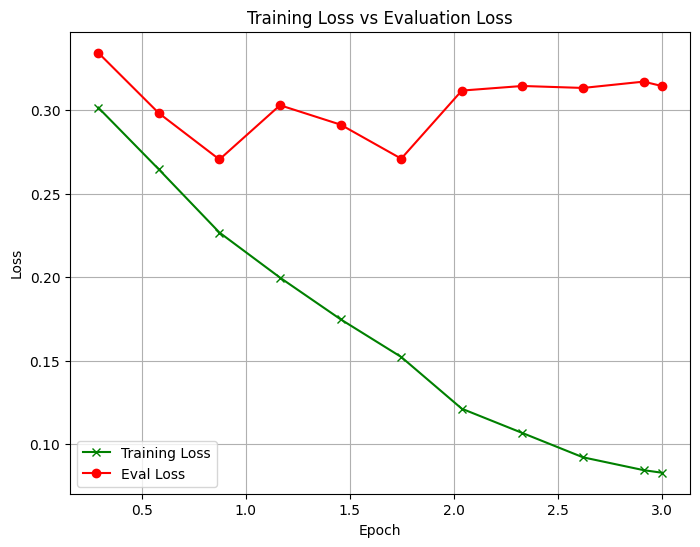

In [108]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

plt.plot(training_results.epoch, training_results.loss, label='Training Loss', color='green', marker='x')
plt.plot(validation_results.epoch, validation_results.loss, label='Eval Loss', color='red', marker='o')

# Labels and Title
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training Loss vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.savefig('bert_base_loss.png')